In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import numpy as np
import warnings as wn
from xhistogram.xarray import histogram as xh
%reload_ext autoreload
%autoreload 2
import esm2m.myfunctions as func

In [2]:
wn.filterwarnings('ignore')
cod = pd.read_csv('species/atlantic_cod.csv', header=0)
bass = pd.read_csv('species/stripped_bass.csv', header=0)
flounder = pd.read_csv('species/summer_flounder.csv', header=0)
seabream = pd.read_csv('species/seabream.csv', header=0)
red_drum = pd.read_csv('species/red_drum.csv', header=0)
n_lampfish = pd.read_csv('species/northern_lampfish.csv', header=0)
blue_lampfish = pd.read_csv('species/blue_lampfish.csv', header=0)
cunner = pd.read_csv('species/cunner.csv', header=0)
eelpout = pd.read_csv('species/eelpout.csv', header=0)

In [3]:
rootdir = '/local/rodgers/MI_JUL13_2020_RCP85'
filename = 'sfc_MI_tropical_ens1*_1x1_1950_2100.nc'
path = rootdir+'/'+filename
trop_all = xr.open_mfdataset(path, engine='netcdf4', concat_dim='ensemble', combine='nested')
trop_avg = trop_all.mean(dim='ensemble')

In [4]:
rootdir = '/local/rodgers/MI_JUL13_2020_RCP85'
filename = 'sfc_MI_ens1*_1x1_1950_2100.nc'
path = rootdir+'/'+filename
bass_all = xr.open_mfdataset(path, engine='netcdf4', concat_dim='ensemble', combine='nested')
bass_avg = bass_all.mean(dim='ensemble')

In [5]:
rootdir = '/local/ss23/NEW_MI'
filename = 'MI_hitemp_sens_k01_ens*_1x1_1950_2100.nc'
path = rootdir+'/'+filename
hi_all = xr.open_mfdataset(path, engine='netcdf4', concat_dim='ensemble', combine='nested')
hi_avg = xr.open_dataset('/home/aos/ystochel/esm2m/data/processed/MI_hitemp_sens_k01_ens130_1x1_1950_2100.nc')

In [6]:
rootdir = '/local/ss23/NEW_MI'
filename = 'MI_k01_ens*_1x1_1950_2100.nc'
path = rootdir+'/'+filename
lo_all = xr.open_mfdataset(path, engine='netcdf4', concat_dim='ensemble', combine='nested')
lo_avg = lo_all.mean(dim='ensemble')

In [7]:
lamp_all = (hi_all+lo_all)/2
lamp_avg = (hi_avg+lo_avg)/2

In [8]:
rootdir = '/local/ss23/GFDL_LEs/'
subdir = 'AREA_FILES_ETC'
filename_area = 'WOA2001_grid.nc'
path_area = rootdir+subdir+'/'+filename_area
area = xr.open_dataset(path_area)['AREA'].rename({'latitude':'yt_ocean','longitude':'xt_ocean'})
area = area.assign_coords({'xt_ocean':trop_avg['xt_ocean'],'yt_ocean':trop_avg['yt_ocean']})
oceanmask = np.isfinite(trop_avg['MI'].isel(time=0).squeeze())
area_masked = area.where(oceanmask,np.nan)
ds_total = ~np.isnan(area.where(oceanmask))
total = ds_total.sum(dim='yt_ocean').sum(dim='xt_ocean')

In [9]:
sea_all = trop_all*2.3
sea_avg = trop_avg*2.3

In [10]:
def get_species(species):
    ds_cod = species.to_xarray()
    lon_bins = np.arange(-180,181)
    lat_bins = np.arange(-90,91)
    species_dist = xh(ds_cod['decimalLatitude'], ds_cod['decimalLongitude'],bins=[lat_bins, lon_bins])
    ds_hab = species_dist.to_dataset().rename({'histogram_decimalLatitude_decimalLongitude':'MI','decimalLatitude_bin':'yt_ocean','decimalLongitude_bin':'xt_ocean'})
    ds_hab = ~np.isnan(ds_hab.where(ds_hab['MI']>0.5))
    return ds_hab

In [11]:
def month(ds, mi, ds_hab, area, num):
    red = ~np.isnan(ds.where(ds['MI']>mi))
    hab = ds_hab.reindex_like(red, method='nearest', tolerance=0.01)
    total_hab = (hab*area).sum(['xt_ocean','yt_ocean'])
    thresh_red = hab*red
    redMonth = thresh_red.groupby('time.year').sum(dim='time').sel(year=slice(1990,2100))
    byMonth = ~np.isnan(redMonth.where(redMonth['MI']>=num))
    redNum = (byMonth*area).sum(['xt_ocean','yt_ocean'])
    # redDen = (byMonth.sel(year=1990)*area_masked).sum(['xt_ocean','yt_ocean'])
    percent = (redNum['MI']/total_hab['MI'])*100
    return percent

In [12]:
def month_90(ds, mi, ds_hab, area, num):
    red = ~np.isnan(ds.where(ds['MI']>mi))
    hab = ds_hab.reindex_like(red, method='nearest', tolerance=0.01)
    total_hab = (hab*area).sum(['xt_ocean','yt_ocean'])
    thresh_red = hab*red
    redMonth = thresh_red.groupby('time.year').sum(dim='time').sel(year=slice(2000,2100))
    byMonth = ~np.isnan(redMonth.where(redMonth['MI']>=num))
    redNum = (byMonth*area).sum(['xt_ocean','yt_ocean'])
    # redDen = (byMonth.sel(year=1990)*area_masked).sum(['xt_ocean','yt_ocean'])
    percent = (redNum['MI']/redNum['MI'].sel(year=2000))*100
    return percent

In [13]:
def month90_emis(ds, mi, ds_hab, area, num, ds_90):
    red = ~np.isnan(ds.where(ds['MI']>mi))
    red85 = ~np.isnan(ds_90.where(ds_90['MI']>mi))
    hab = ds_hab.reindex_like(red, method='nearest', tolerance=0.01)
    total_hab = (hab*area).sum(['xt_ocean','yt_ocean'])
    thresh_red = hab*red
    thresh_red85 = hab*red85
    redMonth = thresh_red.groupby('time.year').sum(dim='time').sel(year=slice(1990,2100))
    redMonth85 = thresh_red85.groupby('time.year').sum(dim='time').sel(year=slice(1990,2100))
    byMonth = ~np.isnan(redMonth.where(redMonth['MI']>=num))
    byMonth85 = ~np.isnan(redMonth85.where(redMonth85['MI']>=num))
    redNum = (byMonth*area).sum(['xt_ocean','yt_ocean'])
    redNum85 = (byMonth85*area).sum(['xt_ocean','yt_ocean'])
    # redDen = (byMonth.sel(year=1990)*area_masked).sum(['xt_ocean','yt_ocean'])
    percent = (redNum['MI']/redNum85['MI'].sel(year=1990))*100
    return percent

# Blue Lampfish

#### E0 = 0.21, A0 = 20.6, MI-crit = 2.6-4.8

In [169]:
blue_hab = get_species(blue_lampfish)
blue_1 = month_90(trop_avg, 3.7, blue_hab, area_masked, 1)
blue_3 = month_90(trop_avg, 3.7, blue_hab, area_masked, 3)
blue_6 = month_90(trop_avg, 3.7, blue_hab, area_masked, 6)
blue_9 = month_90(trop_avg, 3.7, blue_hab, area_masked, 9)
blue_12 = month_90(trop_avg, 3.7, blue_hab, area_masked, 12)

Text(0, 0.5, 'Percent of 1990 Habitat')

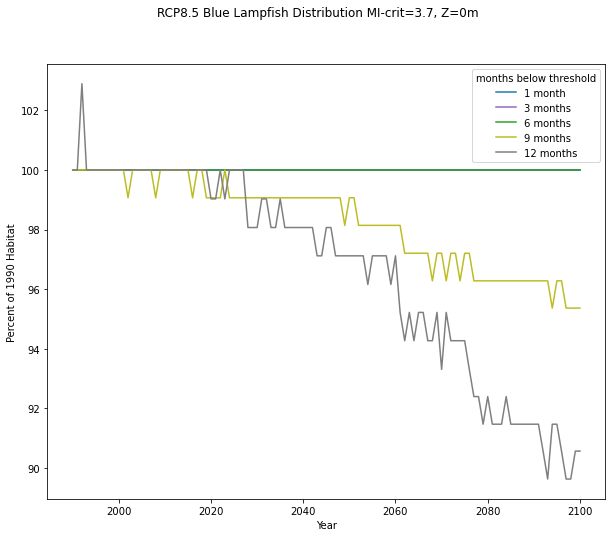

In [137]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Blue Lampfish Distribution MI-crit=3.7, Z=0m')
ax.plot(np.unique(blue_1['year']),blue_1,color='tab:blue',label='1 month')
ax.plot(np.unique(blue_3['year']),blue_3,color='tab:purple',label='3 months')
ax.plot(np.unique(blue_6['year']),blue_6,color='tab:green',label='6 months')
ax.plot(np.unique(blue_9['year']),blue_9,color='tab:olive',label='9 months')
ax.plot(np.unique(blue_12['year']),blue_12,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 Habitat')

In [147]:
blue_1.load()

<xarray.DataArray 'MI' (year: 111)>
array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100.], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 1990 1991 1992 1993 1994 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [44]:
blue_9.load()

<xarray.DataArray 'MI' (year: 111)>
array([100.     , 100.     , 100.     , 100.     , 100.     , 100.     ,
       100.     , 100.     , 100.     , 100.     , 100.     , 100.     ,
        99.06455, 100.     , 100.     , 100.     , 100.     , 100.     ,
        99.06455, 100.     , 100.     , 100.     , 100.     , 100.     ,
       100.     , 100.     ,  99.06455, 100.     , 100.     ,  99.06455,
        99.06455,  99.06455,  99.06455, 100.     ,  99.06455,  99.06455,
        99.06455,  99.06455,  99.06455,  99.06455,  99.06455,  99.06455,
        99.06455,  99.06455,  99.06455,  99.06455,  99.06455,  99.06455,
        99.06455,  99.06455,  99.06455,  99.06455,  99.06455,  99.06455,
        99.06455,  99.06455,  99.06455,  99.06455,  99.06455,  98.13965,
        99.06455,  99.06455,  98.13965,  98.13965,  98.13965,  98.13965,
        98.13965,  98.13965,  98.13965,  98.13965,  98.13965,  98.13965,
        97.2042 ,  97.2042 ,  97.2042 ,  97.2042 ,  97.2042 ,  97.2042 ,
        96.27929,  97.2042 ,  97.2042 ,  96.27929,  97.2042 ,  97.2042 ,
        96.27929,  97.2042 ,  97.2042 ,  96.27929,  96.27929,  96.27929,
        96.27929,  96.27929,  96.27929,  96.27929,  96.27929,  96.27929,
        96.27929,  96.27929,  96.27929,  96.27929,  96.27929,  96.27929,
        96.27929,  96.27929,  95.36521,  96.27929,  96.27929,  95.36521,
        95.36521,  95.36521,  95.36521], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 1990 1991 1992 1993 1994 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [148]:
blue_12.load()

<xarray.DataArray 'MI' (year: 111)>
array([100.      , 100.      , 102.8929  , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
        99.028404,  99.028404, 100.      ,  99.028404, 100.      ,
       100.      , 100.      , 100.      ,  98.06775 ,  98.06775 ,
        98.06775 ,  99.028404,  99.028404,  98.06775 ,  98.06775 ,
        99.028404,  98.06775 ,  98.06775 ,  98.06775 ,  98.06775 ,
        98.06775 ,  98.06775 ,  98.06775 ,  97.11834 ,  97.11834 ,
        98.06775 ,  98.06775 ,  97.11834 ,  97.11834 ,  97.11834 ,
        97.11834 ,  97.11834 ,  97.11834 ,  97.11834 ,  96.1577  ,
        97.11834 ,  97.11834 ,  97.11834 ,  97.11834 ,  96.1577  ,
        97.11834 ,  95.21982 ,  94.27042 ,  95.21982 ,  94.27042 ,
        95.21982 ,  95.21982 ,  94.27042 ,  94.27042 ,  95.21982 ,
        93.30976 ,  95.21982 ,  94.27042 ,  94.27042 ,  94.27042 ,
        94.27042 ,  93.30976 ,  92.395805,  92.395805,  91.46975 ,
        92.395805,  91.46975 ,  91.46975 ,  91.46975 ,  92.395805,
        91.46975 ,  91.46975 ,  91.46975 ,  91.46975 ,  91.46975 ,
        91.46975 ,  91.46975 ,  90.56818 ,  89.6303  ,  91.46975 ,
        91.46975 ,  90.56818 ,  89.6303  ,  89.6303  ,  90.56818 ,
        90.56818 ], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 1990 1991 1992 1993 1994 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [15]:
month_min = [100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100.]
month_max = [100.      , 100.      , 102.8929  , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
        99.028404,  99.028404, 100.      ,  99.028404, 100.      ,
       100.      , 100.      , 100.      ,  98.06775 ,  98.06775 ,
        98.06775 ,  99.028404,  99.028404,  98.06775 ,  98.06775 ,
        99.028404,  98.06775 ,  98.06775 ,  98.06775 ,  98.06775 ,
        98.06775 ,  98.06775 ,  98.06775 ,  97.11834 ,  97.11834 ,
        98.06775 ,  98.06775 ,  97.11834 ,  97.11834 ,  97.11834 ,
        97.11834 ,  97.11834 ,  97.11834 ,  97.11834 ,  96.1577  ,
        97.11834 ,  97.11834 ,  97.11834 ,  97.11834 ,  96.1577  ,
        97.11834 ,  95.21982 ,  94.27042 ,  95.21982 ,  94.27042 ,
        95.21982 ,  95.21982 ,  94.27042 ,  94.27042 ,  95.21982 ,
        93.30976 ,  95.21982 ,  94.27042 ,  94.27042 ,  94.27042 ,
        94.27042 ,  93.30976 ,  92.395805,  92.395805,  91.46975 ,
        92.395805,  91.46975 ,  91.46975 ,  91.46975 ,  92.395805,
        91.46975 ,  91.46975 ,  91.46975 ,  91.46975 ,  91.46975 ,
        91.46975 ,  91.46975 ,  90.56818 ,  89.6303  ,  91.46975 ,
        91.46975 ,  90.56818 ,  89.6303  ,  89.6303  ,  90.56818 ,
        90.56818 ]

In [16]:
month_9 = [100.     , 100.     , 100.     , 100.     , 100.     , 100.     ,
       100.     , 100.     , 100.     , 100.     , 100.     , 100.     ,
        99.06455, 100.     , 100.     , 100.     , 100.     , 100.     ,
        99.06455, 100.     , 100.     , 100.     , 100.     , 100.     ,
       100.     , 100.     ,  99.06455, 100.     , 100.     ,  99.06455,
        99.06455,  99.06455,  99.06455, 100.     ,  99.06455,  99.06455,
        99.06455,  99.06455,  99.06455,  99.06455,  99.06455,  99.06455,
        99.06455,  99.06455,  99.06455,  99.06455,  99.06455,  99.06455,
        99.06455,  99.06455,  99.06455,  99.06455,  99.06455,  99.06455,
        99.06455,  99.06455,  99.06455,  99.06455,  99.06455,  98.13965,
        99.06455,  99.06455,  98.13965,  98.13965,  98.13965,  98.13965,
        98.13965,  98.13965,  98.13965,  98.13965,  98.13965,  98.13965,
        97.2042 ,  97.2042 ,  97.2042 ,  97.2042 ,  97.2042 ,  97.2042 ,
        96.27929,  97.2042 ,  97.2042 ,  96.27929,  97.2042 ,  97.2042 ,
        96.27929,  97.2042 ,  97.2042 ,  96.27929,  96.27929,  96.27929,
        96.27929,  96.27929,  96.27929,  96.27929,  96.27929,  96.27929,
        96.27929,  96.27929,  96.27929,  96.27929,  96.27929,  96.27929,
        96.27929,  96.27929,  95.36521,  96.27929,  96.27929,  95.36521,
        95.36521,  95.36521,  95.36521]

In [17]:
month_avg = [0]*111

In [18]:
years = np.arange(1990,2101)

In [30]:
len(years)

12

In [19]:
for i in range(111):
    month_avg[i]=(month_min[i]+month_max[i])/2

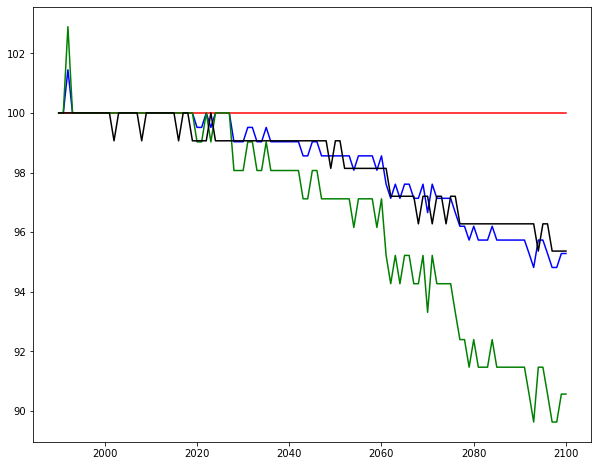

In [46]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(years, month_avg, color='blue')
ax.plot(years, month_min, color='red')
ax.plot(years, month_max, color='green')
ax.plot(years, month_9, color='black')

In [20]:
blue_hab = get_species(blue_lampfish)
blue_min = month_90(trop_avg, 2.6, blue_hab, area_masked, 9)
blue_max = month_90(trop_avg, 4.8, blue_hab, area_masked, 9)

In [21]:
crit_min = [100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100.]
crit_max = [100.      , 109.38822 , 111.312775, 107.565414, 115.26651 ,
       107.5315  , 103.74849 , 101.89179 , 107.5315  , 101.89179 ,
        92.46848 ,  98.10821 ,  98.10821 , 101.8567  ,  90.71926 ,
        94.43043 ,  86.82934 ,  98.10821 ,  90.5767  ,  86.97077 ,
        96.18191 ,  96.251495,  96.251495,  96.18191 ,  85.04448 ,
        96.28714 ,  88.826355,  96.251495,  86.62771 ,  92.37209 ,
        85.00828 ,  92.37209 ,  85.00828 ,  92.3025  ,  85.00828 ,
        86.82934 ,  83.29414 ,  85.00828 ,  82.949936,  79.34401 ,
        81.12887 ,  79.58129 ,  79.58129 ,  77.52295 ,  79.34401 ,
        82.98614 ,  77.52295 ,  75.70189 ,  81.16508 ,  77.52295 ,
        82.949936,  72.13216 ,  70.34729 ,  68.321045,  75.70189 ,
        73.67564 ,  70.10591 ,  66.53618 ,  68.321045,  66.53618 ,
        68.321045,  70.10591 ,  68.321045,  68.321045,  66.53618 ,
        71.89078 ,  68.321045,  68.321045,  66.53618 ,  70.10591 ,
        66.53618 ,  66.53618 ,  66.53618 ,  66.53618 ,  66.53618 ,
        66.53618 ,  66.53618 ,  66.53618 ,  64.67947 ,  66.53618 ,
        66.53618 ,  64.78807 ,  64.78807 ,  62.931355,  66.53618 ,
        66.53618 ,  62.931355,  64.78807 ,  64.78807 ,  64.78807 ,
        62.931355,  62.931355,  59.47239 ,  59.47239 ,  62.931355,
        59.47239 ,  62.931355,  59.47239 ,  62.931355,  62.931355,
        61.18323 ,  59.47239 ,  59.47239 ,  61.18323 ,  59.47239 ,
        57.512177,  61.18323 ,  59.47239 ,  57.512177,  57.512177,
        56.0507  ]

In [112]:
blue_max = [100., 109.38822 , 111.312775, 107.565414, 115.26651 ,
       107.5315  , 103.74849 , 101.89179 , 107.5315  , 101.89179 ,
       100., 100., 100., 101.8567, 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100]
blue_min = [100.      , 100 , 100, 100, 100 ,
       100  , 100 , 100 , 100  , 100 ,
        92.46848 ,  98.10821 ,  98.10821 , 100  ,  90.71926 ,
        94.43043 ,  86.82934 ,  98.10821 ,  90.5767  ,  86.97077 ,
        96.18191 ,  96.251495,  96.251495,  96.18191 ,  85.04448 ,
        96.28714 ,  88.826355,  96.251495,  86.62771 ,  92.37209 ,
        85.00828 ,  92.37209 ,  85.00828 ,  92.3025  ,  85.00828 ,
        86.82934 ,  83.29414 ,  85.00828 ,  82.949936,  79.34401 ,
        81.12887 ,  79.58129 ,  79.58129 ,  77.52295 ,  79.34401 ,
        82.98614 ,  77.52295 ,  75.70189 ,  81.16508 ,  77.52295 ,
        82.949936,  72.13216 ,  70.34729 ,  68.321045,  75.70189 ,
        73.67564 ,  70.10591 ,  66.53618 ,  68.321045,  66.53618 ,
        68.321045,  70.10591 ,  68.321045,  68.321045,  66.53618 ,
        71.89078 ,  68.321045,  68.321045,  66.53618 ,  70.10591 ,
        66.53618 ,  66.53618 ,  66.53618 ,  66.53618 ,  66.53618 ,
        66.53618 ,  66.53618 ,  66.53618 ,  64.67947 ,  66.53618 ,
        66.53618 ,  64.78807 ,  64.78807 ,  62.931355,  66.53618 ,
        66.53618 ,  62.931355,  64.78807 ,  64.78807 ,  64.78807 ,
        62.931355,  62.931355,  59.47239 ,  59.47239 ,  62.931355,
        59.47239 ,  62.931355,  59.47239 ,  62.931355,  62.931355,
        61.18323 ,  59.47239 ,  59.47239 ,  61.18323 ,  59.47239 ,
        57.512177,  61.18323 ,  59.47239 ,  57.512177,  57.512177,
        56.0507  ]

In [110]:
len(blue_max)

111

In [48]:
blue_min.load()

<xarray.DataArray 'MI' (year: 111)>
array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100.], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 1990 1991 1992 1993 1994 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [49]:
blue_max.load()

<xarray.DataArray 'MI' (year: 111)>
array([100.      , 109.38822 , 111.312775, 107.565414, 115.26651 ,
       107.5315  , 103.74849 , 101.89179 , 107.5315  , 101.89179 ,
        92.46848 ,  98.10821 ,  98.10821 , 101.8567  ,  90.71926 ,
        94.43043 ,  86.82934 ,  98.10821 ,  90.5767  ,  86.97077 ,
        96.18191 ,  96.251495,  96.251495,  96.18191 ,  85.04448 ,
        96.28714 ,  88.826355,  96.251495,  86.62771 ,  92.37209 ,
        85.00828 ,  92.37209 ,  85.00828 ,  92.3025  ,  85.00828 ,
        86.82934 ,  83.29414 ,  85.00828 ,  82.949936,  79.34401 ,
        81.12887 ,  79.58129 ,  79.58129 ,  77.52295 ,  79.34401 ,
        82.98614 ,  77.52295 ,  75.70189 ,  81.16508 ,  77.52295 ,
        82.949936,  72.13216 ,  70.34729 ,  68.321045,  75.70189 ,
        73.67564 ,  70.10591 ,  66.53618 ,  68.321045,  66.53618 ,
        68.321045,  70.10591 ,  68.321045,  68.321045,  66.53618 ,
        71.89078 ,  68.321045,  68.321045,  66.53618 ,  70.10591 ,
        66.53618 ,  66.53618 ,  66.53618 ,  66.53618 ,  66.53618 ,
        66.53618 ,  66.53618 ,  66.53618 ,  64.67947 ,  66.53618 ,
        66.53618 ,  64.78807 ,  64.78807 ,  62.931355,  66.53618 ,
        66.53618 ,  62.931355,  64.78807 ,  64.78807 ,  64.78807 ,
        62.931355,  62.931355,  59.47239 ,  59.47239 ,  62.931355,
        59.47239 ,  62.931355,  59.47239 ,  62.931355,  62.931355,
        61.18323 ,  59.47239 ,  59.47239 ,  61.18323 ,  59.47239 ,
        57.512177,  61.18323 ,  59.47239 ,  57.512177,  57.512177,
        56.0507  ], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 1990 1991 1992 1993 1994 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [55]:
blue_hab = func.species_hab(blue_lampfish)
yel_blue = func.mi_hab(trop_all, 2.6, blue_hab, area_masked)
gr_blue = func.mi_hab(trop_all, 3.7, blue_hab, area_masked)
pur_blue = func.mi_hab(trop_all, 4.8, blue_hab, area_masked)

In [56]:
gr_blue.load()

<xarray.DataArray 'MI' (time: 1812)>
array([100.50748356, 100.50748356, 100.50748356, ...,  92.72686928,
        98.88697192, 100.50748356])
Coordinates:
    st_ocean  float64 5.0
  * time      (time) object 1950-01-31 00:00:00 ... 2100-12-31 00:00:00
    year      int64 1990

In [121]:
maximum = [100.0, 109.38822, 111.312775, 107.565414, 115.26651, 107.5315, 103.74849, 
           101.895615, 107.5315, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 
           101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 
           101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 100.94428, 
           101.895615, 101.895615, 101.895615, 101.895615, 100.94244, 101.895615, 101.895615, 
           100.94428, 101.895615, 101.895615, 100.94428, 100.94428, 101.895615, 101.895615, 
           100.953186, 100.0, 101.895615, 100.94428, 101.895615, 101.895615, 101.895615, 
           100.94244, 100.0, 101.895615, 101.895615, 100.94428, 100.0, 101.895615, 100.94428, 
           100.94244, 100.0, 100.0, 100.94244, 101.895615, 100.0, 100.94428, 100.94244, 
           101.895615, 100.0, 100.94244, 100.94428, 101.895615, 100.0, 100.0, 100.94244, 
           100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 
           100.94428, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 
           100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 
           100.0, 100.0, 100.0, 100.0]

In [117]:
print(blue_max)

[100.0, 109.38822, 111.312775, 107.565414, 115.26651, 107.5315, 103.74849, 101.89179, 107.5315, 101.89179, 100.0, 100.0, 100.0, 101.8567, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100]


In [116]:
print(maximum)

[100.0, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 101.895615, 100.94428, 101.895615, 101.895615, 101.895615, 101.895615, 100.94244, 101.895615, 101.895615, 100.94428, 101.895615, 101.895615, 100.94428, 100.94428, 101.895615, 101.895615, 100.953186, 100.0, 101.895615, 100.94428, 101.895615, 101.895615, 101.895615, 100.94244, 100.0, 101.895615, 101.895615, 100.94428, 100.0, 101.895615, 100.94428, 100.94244, 100.0, 100.0, 100.94244, 101.895615, 100.0, 100.94428, 100.94244, 101.895615, 100.0, 100.94244, 100.94428, 101.895615, 100.0, 100.0, 100.94244, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.94428, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100

No handles with labels found to put in legend.


Text(0, 0.5, 'Percent of 1990 Habitat')

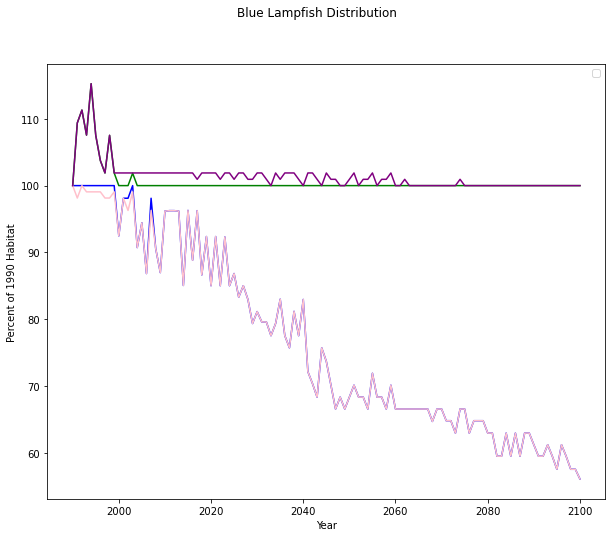

In [122]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Blue Lampfish Distribution')
ax.plot(years, blue_min, color='blue')
ax.plot(years, blue_max, color='green')
ax.plot(years, minimum, color='pink')
ax.plot(years, maximum, color='purple')
# ax.axvline(2000, ymin=0, ymax=1)

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 Habitat')

In [53]:
yel_blue = [100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100.]
gr_blue = [100.        , 100.0187805 , 100.28372021, 100.13314984,
        99.98274447,  99.9879432 , 100.05021248,  99.94079125,
        99.84301299,  99.94119809,  99.78010962,  99.80868388,
        99.71944175,  99.8947164 ,  99.93566889,  99.77033851,
        99.70240147,  99.71549574,  99.58415955,  99.82953363,
        99.73359683,  99.72116142,  99.85005666,  99.73584952,
        99.66064402,  99.63104037,  99.59948209,  99.68410004,
        99.69985877,  99.59113403,  99.54187617,  99.57332716,
        99.5912815 ,  99.50980543,  99.49290159,  99.58081319,
        99.57323583,  99.50644406,  99.43392362,  99.35674011,
        99.45743694,  99.39401738,  99.44455352,  99.33457941,
        99.26804715,  99.44380086,  99.26352637,  99.34078006,
        99.31284923,  99.19648998,  99.30910977,  99.16812661,
        99.22186639,  99.05763911,  99.03588074,  99.22985389,
        99.23921476,  99.13128505,  98.98433705,  98.93346115,
        99.10331121,  99.07428618,  98.86701994,  98.86020292,
        98.78704564,  98.93541271,  98.81373292,  98.81239238,
        98.77867985,  98.7225818 ,  98.71260538,  98.62288291,
        98.26305217,  98.49472469,  98.36974276,  98.56610657,
        98.48488378,  98.43908941,  98.35703909,  98.50716038,
        98.17163521,  98.25444218,  98.45506729,  98.26821872,
        98.31312404,  98.30619214,  98.1931982 ,  97.86290492,
        97.97449192,  97.87948568,  97.83731349,  97.88565593,
        97.6335872 ,  97.8299536 ,  97.86461273,  97.59752493,
        97.65095461,  97.63393943,  97.70853625,  97.68510256,
        97.76936297,  97.5812986 ,  97.48027254,  97.31440864,
        97.39976502,  97.53987448,  97.31000226,  97.08391762,
        97.13276172,  97.43597121,  97.18241353]
pur_blue = [100.        , 101.48603478, 102.96777476, 102.01815106,
       102.99365867, 101.75573637, 101.17841269, 100.65283383,
       101.33343607,  99.50460897,  98.53804461,  98.28213495,
        98.49244808,  99.1581086 ,  96.59664621,  96.03067393,
        95.44670536,  97.29057269,  96.2802094 ,  95.70680008,
        97.62941204,  96.02358554,  97.12509793,  97.99036433,
        95.08744386,  96.98109483,  95.94566689,  96.67100909,
        96.49988827,  96.59387271,  95.55881217,  96.97244418,
        95.09981372,  96.21752503,  94.58007372,  95.35972768,
        95.11469181,  95.08524719,  95.45962004,  94.38165271,
        93.77508323,  91.54066381,  92.44969598,  92.68928324,
        92.300802  ,  92.98145009,  92.27522429,  91.44549549,
        91.79491794,  91.23511392,  93.25399119,  91.3954202 ,
        90.19985577,  89.92484102,  89.38223292,  91.95232239,
        90.45919199,  88.19516554,  88.71329591,  88.4192663 ,
        87.81753678,  88.89713135,  89.55095324,  88.06950467,
        88.72256705,  87.97500221,  87.1614727 ,  87.64637265,
        86.95320559,  87.81730259,  86.82761437,  85.19033351,
        83.50836891,  84.84744735,  84.08090512,  84.16830445,
        83.72246308,  84.85247565,  83.64272834,  83.29767364,
        83.56465117,  81.73750411,  81.66046149,  83.01585884,
        83.97543803,  82.6458313 ,  80.01971296,  80.55191511,
        80.76791366,  81.16111934,  79.34404379,  78.73285042,
        77.52058148,  78.36266173,  78.41153046,  77.51241697,
        78.10660117,  77.48377221,  78.26925129,  78.61910092,
        77.56123507,  76.7773592 ,  76.45507702,  76.14001799,
        76.28257746,  77.98894791,  76.64713088,  76.47019817,
        75.77818515,  74.63451751,  74.33389848]

In [57]:
yel_blue.load()

<xarray.DataArray 'MI' (time: 1812)>
array([99.99999904, 99.99999904, 99.99999904, ..., 99.99999904,
       99.99999904, 99.99999904])
Coordinates:
    st_ocean  float64 5.0
  * time      (time) object 1950-01-31 00:00:00 ... 2100-12-31 00:00:00
    year      int64 1990

In [58]:
pur_blue.load()

<xarray.DataArray 'MI' (time: 1812)>
array([145.26588817, 146.62345806, 147.22470198, ...,  34.75640429,
        60.55035148,  99.80406972])
Coordinates:
    st_ocean  float64 5.0
  * time      (time) object 1950-01-31 00:00:00 ... 2100-12-31 00:00:00
    year      int64 1990

In [160]:
crit_maxOrig = [100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100.]
crit_minOrig = [100.        , 101.48603478, 102.96777476, 102.01815106,
       102.99365867, 101.75573637, 101.17841269, 100.65283383,
       101.33343607,  99.50460897,  98.53804461,  98.28213495,
        98.49244808,  99.1581086 ,  96.59664621,  96.03067393,
        95.44670536,  97.29057269,  96.2802094 ,  95.70680008,
        97.62941204,  96.02358554,  97.12509793,  97.99036433,
        95.08744386,  96.98109483,  95.94566689,  96.67100909,
        96.49988827,  96.59387271,  95.55881217,  96.97244418,
        95.09981372,  96.21752503,  94.58007372,  95.35972768,
        95.11469181,  95.08524719,  95.45962004,  94.38165271,
        93.77508323,  91.54066381,  92.44969598,  92.68928324,
        92.300802  ,  92.98145009,  92.27522429,  91.44549549,
        91.79491794,  91.23511392,  93.25399119,  91.3954202 ,
        90.19985577,  89.92484102,  89.38223292,  91.95232239,
        90.45919199,  88.19516554,  88.71329591,  88.4192663 ,
        87.81753678,  88.89713135,  89.55095324,  88.06950467,
        88.72256705,  87.97500221,  87.1614727 ,  87.64637265,
        86.95320559,  87.81730259,  86.82761437,  85.19033351,
        83.50836891,  84.84744735,  84.08090512,  84.16830445,
        83.72246308,  84.85247565,  83.64272834,  83.29767364,
        83.56465117,  81.73750411,  81.66046149,  83.01585884,
        83.97543803,  82.6458313 ,  80.01971296,  80.55191511,
        80.76791366,  81.16111934,  79.34404379,  78.73285042,
        77.52058148,  78.36266173,  78.41153046,  77.51241697,
        78.10660117,  77.48377221,  78.26925129,  78.61910092,
        77.56123507,  76.7773592 ,  76.45507702,  76.14001799,
        76.28257746,  77.98894791,  76.64713088,  76.47019817,
        75.77818515,  74.63451751,  74.33389848]

In [24]:
blue_hab = get_species(blue_lampfish)
blue_ens = month_90(trop_all, 3.7, blue_hab, area_masked, 9)
min_ens = blue_ens.min(dim='ensemble')
max_ens = blue_ens.max(dim='ensemble')

In [55]:
min_ens.load()

<xarray.DataArray 'MI' (year: 111)>
array([100.      ,  98.13965 , 100.      ,  99.06455 ,  99.06455 ,
        99.06455 ,  99.06455 ,  98.13965 ,  98.13965 ,  99.06455 ,
        99.06455 ,  98.13965 ,  96.27929 ,  99.06455 ,  99.06455 ,
        99.06455 ,  98.13965 ,  96.27929 ,  98.13965 ,  99.06455 ,
        99.06455 ,  96.27929 ,  99.06455 ,  98.13965 ,  98.13965 ,
        99.06455 ,  98.13965 ,  98.13965 ,  99.06455 ,  98.13965 ,
        98.13965 ,  99.06455 ,  97.21474 ,  96.27929 ,  96.27929 ,
        98.13965 ,  97.2042  ,  98.13965 ,  98.13965 ,  98.13965 ,
        98.13965 ,  97.2042  ,  96.27929 ,  97.2042  ,  96.27929 ,
        96.27929 ,  96.27929 ,  97.2042  ,  98.13965 ,  96.27929 ,
        97.2042  ,  96.27929 ,  97.2042  ,  97.2042  ,  96.27929 ,
        98.13965 ,  96.27929 ,  96.27929 ,  96.27929 ,  96.27929 ,
        96.27929 ,  96.27929 ,  95.36521 ,  96.27929 ,  96.27929 ,
        96.27929 ,  96.27929 ,  95.36521 ,  96.27929 ,  96.27929 ,
        95.36521 ,  96.27929 ,  94.46222 ,  95.34384 ,  95.36521 ,
        95.36521 ,  96.27929 ,  95.36521 ,  94.46222 ,  96.27929 ,
        96.27929 ,  95.36521 ,  95.36521 ,  95.36521 ,  95.36521 ,
        95.36521 ,  94.46222 ,  94.41893 ,  96.27929 ,  93.50485 ,
        93.50485 ,  93.53732 ,  92.57995 ,  95.36521 ,  93.50485 ,
        92.601875,  93.53732 ,  93.46061 ,  94.46222 ,  93.50485 ,
        94.41893 ,  91.76577 ,  91.68779 ,  92.4834  ,  92.601875,
        92.601875,  91.68779 ,  89.8932  ,  90.762886,  93.50485 ,
        89.871284], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 1990 1991 1992 1993 1994 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [56]:
max_ens.load()

<xarray.DataArray 'MI' (year: 111)>
array([100.      , 101.895615, 101.895615, 101.895615, 101.895615,
       101.895615, 101.895615, 101.895615, 101.895615, 101.895615,
       101.895615, 101.895615, 101.895615, 101.895615, 101.895615,
       101.895615, 101.895615, 101.895615, 101.895615, 101.895615,
       101.895615, 101.895615, 101.895615, 101.895615, 101.895615,
       101.895615, 101.895615, 100.94428 , 101.895615, 101.895615,
       101.895615, 101.895615, 100.94244 , 101.895615, 101.895615,
       100.94428 , 101.895615, 101.895615, 100.94428 , 100.94428 ,
       101.895615, 101.895615, 100.953186, 100.      , 101.895615,
       100.94428 , 101.895615, 101.895615, 101.895615, 100.94244 ,
       100.      , 101.895615, 101.895615, 100.94428 , 100.      ,
       101.895615, 100.94428 , 100.94244 , 100.      , 100.      ,
       100.94244 , 101.895615, 100.      , 100.94428 , 100.94244 ,
       101.895615, 100.      , 100.94244 , 100.94428 , 101.895615,
       100.      , 100.      , 100.94244 , 100.      , 100.      ,
        99.06455 , 100.      , 100.      , 100.      , 100.      ,
        99.06455 ,  99.06455 , 100.      , 100.      , 100.94428 ,
       100.      ,  99.06455 ,  99.06455 ,  98.13965 ,  98.13965 ,
        99.06455 , 100.      ,  98.13965 ,  99.0751  ,  99.06637 ,
        98.13965 ,  99.04682 ,  98.12672 ,  98.13965 ,  99.04682 ,
        98.10438 ,  98.13965 ,  98.13965 ,  99.04682 ,  98.10438 ,
        98.13965 ,  98.10438 ,  99.06455 ,  98.10438 ,  98.10438 ,
        98.10438 ], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 1990 1991 1992 1993 1994 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [146]:
min_ens = [100.      ,  98.13965 , 100.      ,  99.06455 ,  99.06455 ,
        99.06455 ,  99.06455 ,  98.13965 ,  98.13965 ,  99.06455 ,
        99.06455 ,  98.13965 ,  96.27929 ,  99.06455 ,  99.06455 ,
        99.06455 ,  98.13965 ,  96.27929 ,  98.13965 ,  99.06455 ,
        99.06455 ,  96.27929 ,  99.06455 ,  98.13965 ,  98.13965 ,
        99.06455 ,  98.13965 ,  98.13965 ,  99.06455 ,  98.13965 ,
        98.13965 ,  99.06455 ,  97.21474 ,  96.27929 ,  96.27929 ,
        98.13965 ,  97.2042  ,  98.13965 ,  98.13965 ,  98.13965 ,
        98.13965 ,  97.2042  ,  96.27929 ,  97.2042  ,  96.27929 ,
        96.27929 ,  96.27929 ,  97.2042  ,  98.13965 ,  96.27929 ,
        97.2042  ,  96.27929 ,  97.2042  ,  97.2042  ,  96.27929 ,
        98.13965 ,  96.27929 ,  96.27929 ,  96.27929 ,  96.27929 ,
        96.27929 ,  96.27929 ,  95.36521 ,  96.27929 ,  96.27929 ,
        96.27929 ,  96.27929 ,  95.36521 ,  96.27929 ,  96.27929 ,
        95.36521 ,  96.27929 ,  94.46222 ,  95.34384 ,  95.36521 ,
        95.36521 ,  96.27929 ,  95.36521 ,  94.46222 ,  96.27929 ,
        96.27929 ,  95.36521 ,  95.36521 ,  95.36521 ,  95.36521 ,
        95.36521 ,  94.46222 ,  94.41893 ,  96.27929 ,  93.50485 ,
        93.50485 ,  93.53732 ,  92.57995 ,  95.36521 ,  93.50485 ,
        92.601875,  93.53732 ,  93.46061 ,  94.46222 ,  93.50485 ,
        94.41893 ,  91.76577 ,  91.68779 ,  92.4834  ,  92.601875,
        92.601875,  91.68779 ,  89.8932  ,  90.762886,  93.50485 ,
        89.871284]
max_ens = [100.      , 101.895615, 101.895615, 101.895615, 101.895615,
       101.895615, 101.895615, 101.895615, 101.895615, 101.895615,
       101.895615, 101.895615, 101.895615, 101.895615, 101.895615,
       101.895615, 101.895615, 101.895615, 101.895615, 101.895615,
       101.895615, 101.895615, 101.895615, 101.895615, 101.895615,
       101.895615, 101.895615, 100.94428 , 101.895615, 101.895615,
       101.895615, 101.895615, 100.94244 , 101.895615, 101.895615,
       100.94428 , 101.895615, 101.895615, 100.94428 , 100.94428 ,
       101.895615, 101.895615, 100.953186, 100.      , 101.895615,
       100.94428 , 101.895615, 101.895615, 101.895615, 100.94244 ,
       100.      , 101.895615, 101.895615, 100.94428 , 100.      ,
       101.895615, 100.94428 , 100.94244 , 100.      , 100.      ,
       100.94244 , 101.895615, 100.      , 100.94428 , 100.94244 ,
       101.895615, 100.      , 100.94244 , 100.94428 , 101.895615,
       100.      , 100.      , 100.94244 , 100.      , 100.      ,
        99.06455 , 100.      , 100.      , 100.      , 100.      ,
        99.06455 ,  99.06455 , 100.      , 100.      , 100.94428 ,
       100.      ,  99.06455 ,  99.06455 ,  98.13965 ,  98.13965 ,
        99.06455 , 100.      ,  98.13965 ,  99.0751  ,  99.06637 ,
        98.13965 ,  99.04682 ,  98.12672 ,  98.13965 ,  99.04682 ,
        98.10438 ,  98.13965 ,  98.13965 ,  99.04682 ,  98.10438 ,
        98.13965 ,  98.10438 ,  99.06455 ,  98.10438 ,  98.10438 ,
        98.10438 ]

In [14]:
maximum = [0]*111
minimum = [0]*111
difference = [0]*111
crit_diff = [0]*111
ens_diff = [0]*111
month_diff = [0]*111

In [24]:
def find_max(a, b, c): 
    if (a >= b) and (a >= c): 
        largest = a 
  
    elif (b >= a) and (b >= c): 
        largest = b 
    else: 
        largest = c 
          
    return largest 

def find_min(a, b, c):
    if (a < b) and (a < c):
        smallest_num = a
    elif (b < a) and (b < c):
        smallest_num = b
    else:
        smallest_num = c
    return smallest_num

In [35]:
for i in range(111):
    maximum[i] = find_max(blue_min[i], month_min[i], max_ens[i])
    minimum[i] = find_min(blue_max[i], month_max[i], min_ens[i])

In [133]:
for i in range(111):
    difference[i] = maximum[i]-minimum[i]

In [38]:
difference[0]=1

In [154]:
total[0]=1

In [163]:
crit = [0]*111
month = [0]*111
ens = [0]*111
for i in range(111):
    crit_diff[i] = (blue_max[i]-blue_min[i])
    month_diff[i] = (month_min[i]-month_max[i])
    ens_diff[i] = (max_ens[i]-min_ens[i])
for i in range(111):
    total[i] = crit_diff[i]+month_diff[i]+ens_diff[i]
total[0]=1
for i in range(111):
    crit[i] = (difference[i]*crit_diff[i])/total[i]
    month[i] = (difference[i]*month_diff[i])/total[i]
    ens[i] = (difference[i]*ens_diff[i])/total[i]
added = [0]*111
for i in range(111):
    added[i] = crit[i]+month[i]+ens[i]

In [151]:
total = [0]*111

In [137]:
for i in range(111):
    total[i] = crit_diff[i]+month_diff[i]+ens_diff[i]

In [134]:
difference[0]=1

In [136]:
mi_crit = [0]*111
month = [0]*111
ens = [0]*111
for i in range(111):
    mi_crit[i] = (crit_diff[i]/difference[i])*100
    month[i] = (month_diff[i]/difference[i])*100
    ens[i] = (ens_diff[i]/difference[i])*100

In [166]:
crit_line = [0]*111
for i in range(111):
    crit_line[i] = maximum[i]-crit[i]
month_line = [0]*111
for i in range(111):
    month_line[i] = crit_line[i]-month[i]
ens_line = [0]*111
for i in range(111):
    ens_line[i] = month_line[i]-ens[i]

Text(0, 0.5, 'Percent of 1990 Habitat')

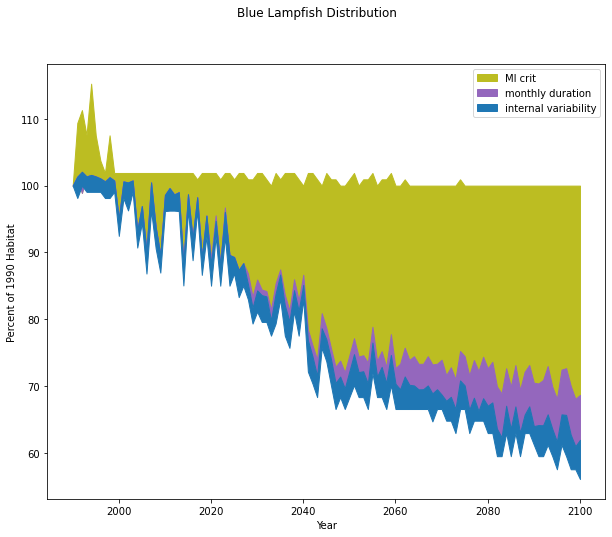

In [167]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Blue Lampfish Distribution')
ax.fill_between(years, maximum, crit_line, color='tab:olive', label='MI crit')
ax.fill_between(years, crit_line, month_line, color='tab:purple', label ='monthly duration')
ax.fill_between(years, month_line, ens_line, color='tab:blue', label='internal variability')

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 Habitat')

In [70]:
firsts = 0
for i in range(20):
    firsts = firsts + blue_max[i]

Text(0, 0.5, 'Percent of 1990 Habitat')

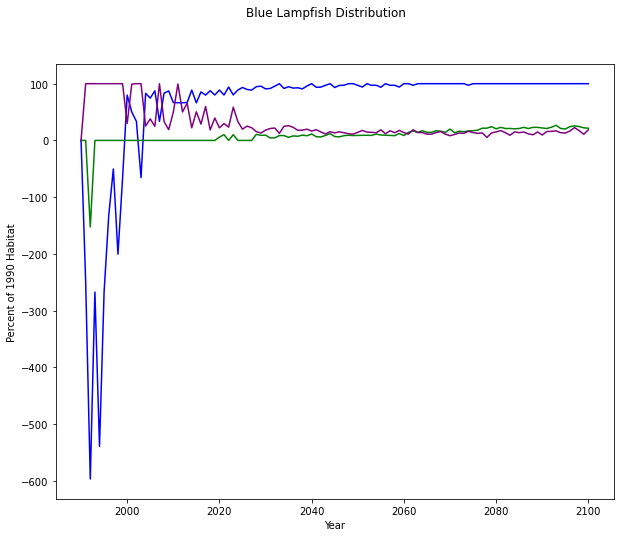

In [98]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Blue Lampfish Distribution')
ax.plot(years, mi_crit, color='blue')
ax.plot(years, month, color='green')
ax.plot(years, ens, color='purple')
# ax.axvline(2000, ymin=0, ymax=1)

# ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 Habitat')

In [100]:
blue_max[1]=109.38822
blue_max[2] = 111.312775
blue_max[3]= 107.565414
blue_max[4] = 115.26651
blue_max[5]= 107.5315
blue_max[6] = 103.74849
blue_max[7]= 101.89179
blue_max[8] = 107.5315
blue_max[9]= 101.89179

Text(0, 0.5, 'Percent of 1990 Habitat')

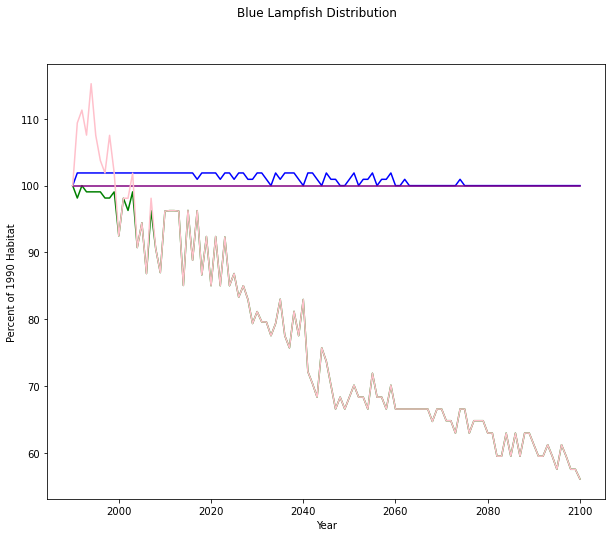

In [61]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Blue Lampfish Distribution')
ax.plot(years, maximum, color='blue')
ax.plot(years, minimum, color='green')
ax.plot(years, blue_min, color='purple')
ax.plot(years, blue_max, color='pink')
# ax.axvline(2000, ymin=0, ymax=1)

# ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 Habitat')

No handles with labels found to put in legend.


Text(0, 0.5, 'Percent of 1990 Habitat')

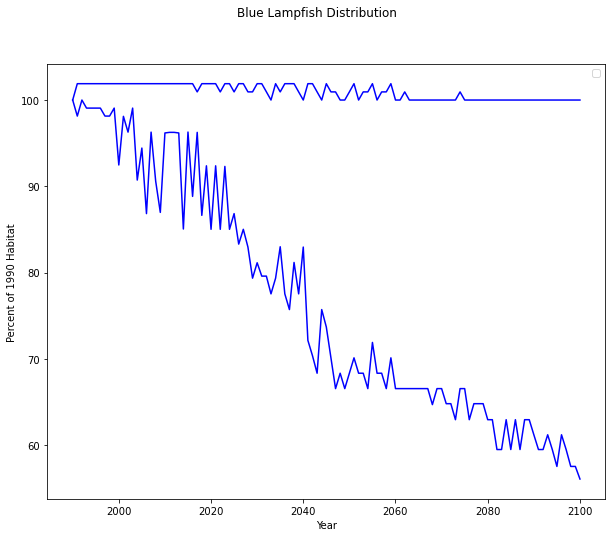

In [74]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Blue Lampfish Distribution')
ax.plot(years, maximum, color='blue')
ax.plot(years, minimum, color='blue')

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 Habitat')

Text(0, 0.5, 'Percent of 1990 Habitat')

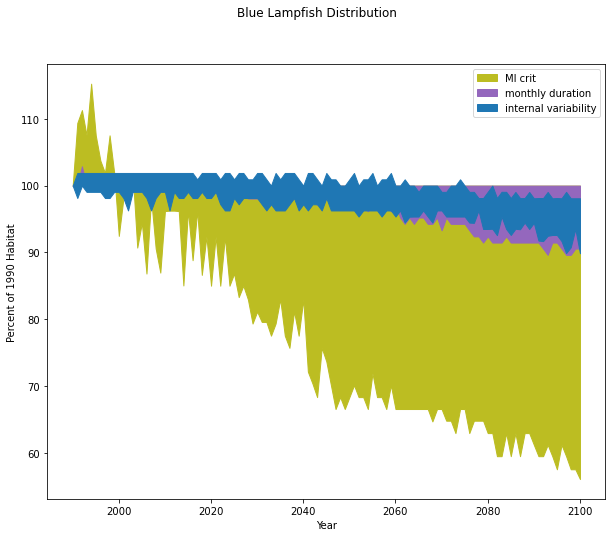

In [59]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Blue Lampfish Distribution')
ax.fill_between(years, blue_min, blue_max, color='tab:olive', label='MI crit')
ax.fill_between(years, month_min, month_max, color='tab:purple', label ='monthly duration')
ax.fill_between(years, min_ens, max_ens, color='tab:blue', label='internal variability')

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 Habitat')

Text(0, 0.5, 'Percent of 1990 Habitat')

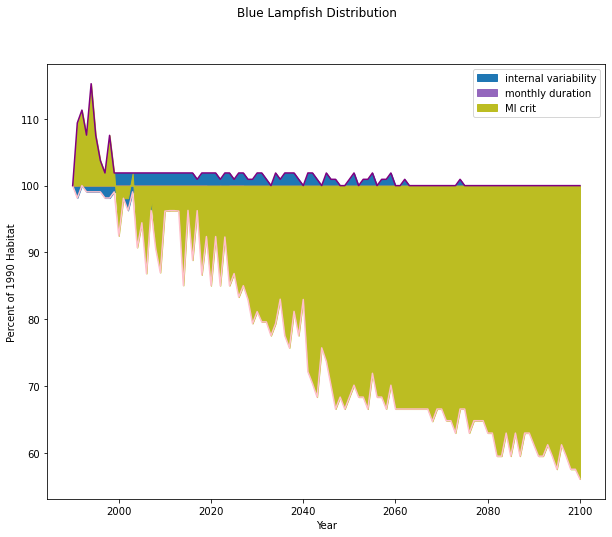

In [149]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Blue Lampfish Distribution')
ax.fill_between(years, min_ens, max_ens, color='tab:blue', label='internal variability')
ax.fill_between(years, month_min, month_max, color='tab:purple', label ='monthly duration')
ax.fill_between(years, crit_min, crit_max, color='tab:olive', label='MI crit')
ax.plot(years, minimum, color='pink')
ax.plot(years, maximum, color='purple')

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 Habitat')

Text(0, 0.5, 'Percent of 1990 Habitat')

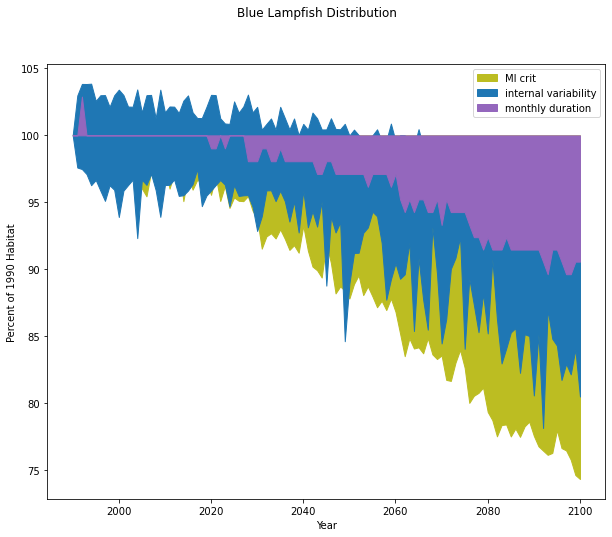

In [165]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Blue Lampfish Distribution')
ax.fill_between(years, crit_minOrig, crit_maxOrig, color='tab:olive', label='MI crit')
ax.fill_between(years, ens_min, ens_max, color='tab:blue', label='internal variability')
ax.fill_between(years, month_min, month_max, color='tab:purple', label ='monthly duration')

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 Habitat')

# 2000

In [16]:
blue_hab = get_species(blue_lampfish)
blue_1 = month_90(trop_avg, 3.7, blue_hab, area_masked, 1)
blue_3 = month_90(trop_avg, 3.7, blue_hab, area_masked, 3)
blue_6 = month_90(trop_avg, 3.7, blue_hab, area_masked, 6)
blue_9 = month_90(trop_avg, 3.7, blue_hab, area_masked, 9)
blue_12 = month_90(trop_avg, 3.7, blue_hab, area_masked, 12)

Text(0, 0.5, 'Percent of 1990 Habitat')

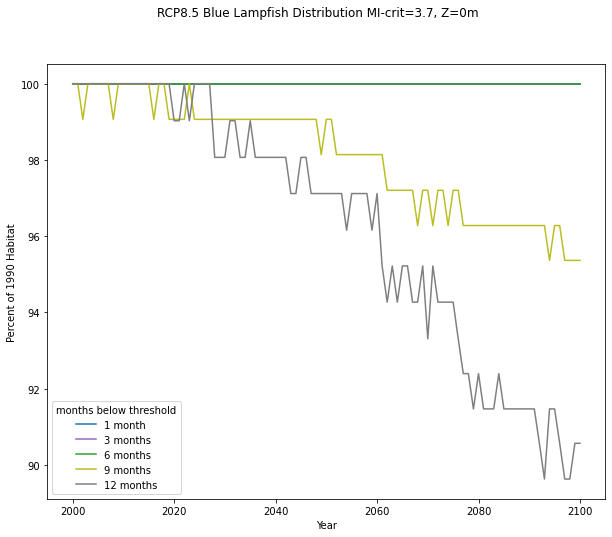

In [172]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Blue Lampfish Distribution MI-crit=3.7, Z=0m')
ax.plot(np.unique(blue_1['year']),blue_1,color='tab:blue',label='1 month')
ax.plot(np.unique(blue_3['year']),blue_3,color='tab:purple',label='3 months')
ax.plot(np.unique(blue_6['year']),blue_6,color='tab:green',label='6 months')
ax.plot(np.unique(blue_9['year']),blue_9,color='tab:olive',label='9 months')
ax.plot(np.unique(blue_12['year']),blue_12,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 Habitat')

In [16]:
monthMax[0] = 100
monthMax[1] = 100
monthMax[99] = 100
monthMax[100] = 100

monthMin[0] = 100
monthMin[1] = 100
monthMin[99] = 90.09924
monthMin[100] = 90.255553

In [15]:
monthMin = [0]*101
x = np.arange(2,99)
for i in x:
    monthMin[i] = (month_min[i-2]+month_min[i-1]+month_min[i]+month_min[i+1]+month_min[i+2])/5
monthMax = [0]*101
x = np.arange(2,99)
for i in x:
    monthMax[i] = (month_max[i-2]+month_max[i-1]+month_max[i]+month_max[i+1]+month_max[i+2])/5

In [14]:
month_max = [100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100.]
month_min = [100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
        99.028404,  99.028404, 100.      ,  99.028404, 100.      ,
       100.      , 100.      , 100.      ,  98.06775 ,  98.06775 ,
        98.06775 ,  99.028404,  99.028404,  98.06775 ,  98.06775 ,
        99.028404,  98.06775 ,  98.06775 ,  98.06775 ,  98.06775 ,
        98.06775 ,  98.06775 ,  98.06775 ,  97.11834 ,  97.11834 ,
        98.06775 ,  98.06775 ,  97.11834 ,  97.11834 ,  97.11834 ,
        97.11834 ,  97.11834 ,  97.11834 ,  97.11834 ,  96.1577  ,
        97.11834 ,  97.11834 ,  97.11834 ,  97.11834 ,  96.1577  ,
        97.11834 ,  95.21982 ,  94.27042 ,  95.21982 ,  94.27042 ,
        95.21982 ,  95.21982 ,  94.27042 ,  94.27042 ,  95.21982 ,
        93.30976 ,  95.21982 ,  94.27042 ,  94.27042 ,  94.27042 ,
        94.27042 ,  93.30976 ,  92.395805,  92.395805,  91.46975 ,
        92.395805,  91.46975 ,  91.46975 ,  91.46975 ,  92.395805,
        91.46975 ,  91.46975 ,  91.46975 ,  91.46975 ,  91.46975 ,
        91.46975 ,  91.46975 ,  90.56818 ,  89.6303  ,  91.46975 ,
        91.46975 ,  90.56818 ,  89.6303  ,  89.6303  ,  90.56818 ,
        90.56818 ]

In [175]:
blue_1.load()

<xarray.DataArray 'MI' (year: 101)>
array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100.], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 2000 2001 2002 2003 2004 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [176]:
blue_12.load()

<xarray.DataArray 'MI' (year: 101)>
array([100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
        99.028404,  99.028404, 100.      ,  99.028404, 100.      ,
       100.      , 100.      , 100.      ,  98.06775 ,  98.06775 ,
        98.06775 ,  99.028404,  99.028404,  98.06775 ,  98.06775 ,
        99.028404,  98.06775 ,  98.06775 ,  98.06775 ,  98.06775 ,
        98.06775 ,  98.06775 ,  98.06775 ,  97.11834 ,  97.11834 ,
        98.06775 ,  98.06775 ,  97.11834 ,  97.11834 ,  97.11834 ,
        97.11834 ,  97.11834 ,  97.11834 ,  97.11834 ,  96.1577  ,
        97.11834 ,  97.11834 ,  97.11834 ,  97.11834 ,  96.1577  ,
        97.11834 ,  95.21982 ,  94.27042 ,  95.21982 ,  94.27042 ,
        95.21982 ,  95.21982 ,  94.27042 ,  94.27042 ,  95.21982 ,
        93.30976 ,  95.21982 ,  94.27042 ,  94.27042 ,  94.27042 ,
        94.27042 ,  93.30976 ,  92.395805,  92.395805,  91.46975 ,
        92.395805,  91.46975 ,  91.46975 ,  91.46975 ,  92.395805,
        91.46975 ,  91.46975 ,  91.46975 ,  91.46975 ,  91.46975 ,
        91.46975 ,  91.46975 ,  90.56818 ,  89.6303  ,  91.46975 ,
        91.46975 ,  90.56818 ,  89.6303  ,  89.6303  ,  90.56818 ,
        90.56818 ], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 2000 2001 2002 2003 2004 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [19]:
critMax[0] = 100
critMax[1] = 100
critMax[99] = 100
critMax[100] = 100

critMin[0] = 100
critMin[1] = 100
critMin[99] = 62.331359
critMin[100] = 61.669682

In [18]:
critMin = [0]*101
x = np.arange(2,99)
for i in x:
    critMin[i] = (crit_min[i-2]+crit_min[i-1]+crit_min[i]+crit_min[i+1]+crit_min[i+2])/5
critMax = [0]*101
x = np.arange(2,99)
for i in x:
    critMax[i] = (crit_max[i-2]+crit_max[i-1]+crit_max[i]+crit_max[i+1]+crit_max[i+2])/5

In [180]:
blue_hab = get_species(blue_lampfish)
crit_min = month_90(trop_avg, 2.6, blue_hab, area_masked, 9)
crit_max = month_90(trop_avg, 4.8, blue_hab, area_masked, 9)

In [17]:
crit_max = [100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100.]
crit_min = [100.      , 100 , 100 , 100,  98.10831 ,
       100 ,  93.90155 , 100 ,  97.95413 ,  94.054504,
       100, 100 , 100 , 100,  91.97131 ,
       100,  96.061226, 100 ,  93.6835  ,  99.89576 ,
        91.93217 ,  99.89576 ,  91.93217 ,  99.8205  ,  91.93217 ,
        93.90155 ,  90.07842 ,  91.93217 ,  89.70617 ,  85.80655 ,
        87.736786,  86.063156,  86.063156,  83.83716 ,  85.80655 ,
        89.74532 ,  83.83716 ,  81.867775,  87.77593 ,  83.83716 ,
        89.70617 ,  78.00729 ,  76.07704 ,  73.885765,  81.867775,
        79.67649 ,  75.816   ,  71.95553 ,  73.885765,  71.95553 ,
        73.885765,  75.816   ,  73.885765,  73.885765,  71.95553 ,
        77.746254,  73.885765,  73.885765,  71.95553 ,  75.816   ,
        71.95553 ,  71.95553 ,  71.95553 ,  71.95553 ,  71.95553 ,
        71.95553 ,  71.95553 ,  71.95553 ,  69.947586,  71.95553 ,
        71.95553 ,  70.065025,  70.065025,  68.05708 ,  71.95553 ,
        71.95553 ,  68.05708 ,  70.065025,  70.065025,  70.065025,
        68.05708 ,  68.05708 ,  64.31639 ,  64.31639 ,  68.05708 ,
        64.31639 ,  68.05708 ,  64.31639 ,  68.05708 ,  68.05708 ,
        66.16659 ,  64.31639 ,  64.31639 ,  66.16659 ,  64.31639 ,
        62.196518,  66.16659 ,  64.31639 ,  62.196518,  62.196518,
        60.61601 ]

In [182]:
crit_min.load()

<xarray.DataArray 'MI' (year: 101)>
array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100.], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 2000 2001 2002 2003 2004 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [183]:
crit_max.load()

<xarray.DataArray 'MI' (year: 101)>
array([100.      , 106.09908 , 106.09908 , 110.152885,  98.10831 ,
       102.12175 ,  93.90155 , 106.09908 ,  97.95413 ,  94.054504,
       104.015884, 104.09113 , 104.09113 , 104.015884,  91.97131 ,
       104.129684,  96.061226, 104.09113 ,  93.6835  ,  99.89576 ,
        91.93217 ,  99.89576 ,  91.93217 ,  99.8205  ,  91.93217 ,
        93.90155 ,  90.07842 ,  91.93217 ,  89.70617 ,  85.80655 ,
        87.736786,  86.063156,  86.063156,  83.83716 ,  85.80655 ,
        89.74532 ,  83.83716 ,  81.867775,  87.77593 ,  83.83716 ,
        89.70617 ,  78.00729 ,  76.07704 ,  73.885765,  81.867775,
        79.67649 ,  75.816   ,  71.95553 ,  73.885765,  71.95553 ,
        73.885765,  75.816   ,  73.885765,  73.885765,  71.95553 ,
        77.746254,  73.885765,  73.885765,  71.95553 ,  75.816   ,
        71.95553 ,  71.95553 ,  71.95553 ,  71.95553 ,  71.95553 ,
        71.95553 ,  71.95553 ,  71.95553 ,  69.947586,  71.95553 ,
        71.95553 ,  70.065025,  70.065025,  68.05708 ,  71.95553 ,
        71.95553 ,  68.05708 ,  70.065025,  70.065025,  70.065025,
        68.05708 ,  68.05708 ,  64.31639 ,  64.31639 ,  68.05708 ,
        64.31639 ,  68.05708 ,  64.31639 ,  68.05708 ,  68.05708 ,
        66.16659 ,  64.31639 ,  64.31639 ,  66.16659 ,  64.31639 ,
        62.196518,  66.16659 ,  64.31639 ,  62.196518,  62.196518,
        60.61601 ], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 2000 2001 2002 2003 2004 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [184]:
blue_hab = get_species(blue_lampfish)
blue_ens = month_90(trop_all, 3.7, blue_hab, area_masked, 9)
ens_min = blue_ens.min(dim='ensemble')
ens_max = blue_ens.max(dim='ensemble')

In [22]:
ensMax[0] = 100.62952
ensMax[1] = 100.70821
ensMax[99] = 97.6574675
ensMax[100] = 97.18844

ensMin[0] = 98.442696
ensMin[1] = 98.59816
ensMin[99] = 91.2202675
ensMin[100] = 91.379673

In [21]:
ensMin = [0]*101
x = np.arange(2,99)
for i in x:
    ensMin[i] = (ens_min[i-2]+ens_min[i-1]+ens_min[i]+ens_min[i+1]+ens_min[i+2])/5
ensMax = [0]*101
x = np.arange(2,99)
for i in x:
    ensMax[i] = (ens_max[i-2]+ens_max[i-1]+ens_max[i]+ens_max[i+1]+ens_max[i+2])/5

In [20]:
ens_min = [100.      ,  98.13965 ,  97.18844 ,  99.06455 ,  99.06455 ,
        99.06455 ,  98.13965 ,  96.27929 ,  98.13965 ,  99.06455 ,
        98.13965 ,  96.27929 ,  99.06455 ,  98.13965 ,  99.06455 ,
        99.06455 ,  98.13965 ,  98.13965 ,  98.13965 ,  98.13965 ,
        98.13965 ,  99.06455 ,  98.13272 ,  97.18844 ,  96.27929 ,
        98.13965 ,  97.2042  ,  98.13965 ,  98.13965 ,  98.13965 ,
        98.13965 ,  96.27929 ,  96.27929 ,  97.2042  ,  96.27929 ,
        97.18844 ,  96.27929 ,  98.122086,  98.13965 ,  96.27929 ,
        97.2042  ,  96.27929 ,  97.2042  ,  97.18844 ,  96.27929 ,
        98.13965 ,  96.27929 ,  97.18844 ,  96.27929 ,  96.27929 ,
        96.27929 ,  96.27929 ,  95.36521 ,  96.27929 ,  96.27929 ,
        96.27929 ,  96.27929 ,  96.265724,  96.27929 ,  96.27929 ,
        96.265724,  96.27929 ,  94.46222 ,  95.34384 ,  95.36521 ,
        95.36521 ,  96.27929 ,  95.36521 ,  95.35422 ,  96.27929 ,
        95.36521 ,  95.36521 ,  95.36521 ,  95.36521 ,  95.36521 ,
        95.36521 ,  95.35422 ,  94.41893 ,  96.27929 ,  93.50485 ,
        93.50485 ,  94.41893 ,  92.57995 ,  95.36521 ,  93.50485 ,
        92.601875,  93.53732 ,  91.72192 ,  94.46222 ,  94.3878  ,
        94.41893 ,  92.601875,  91.68779 ,  91.61994 ,  92.601875,
        92.601875,  92.55357 ,  90.74205 ,  90.762886,  93.50485 ,
        89.871284]
ens_max = [100.      , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.      ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.      , 100.94428 , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.94428 , 100.      ,
       100.      , 100.      ,  99.06637 ,  99.06637 ,  99.06637 ,
        99.06637 , 100.      , 100.      , 100.      , 100.      ,
       100.      ,  99.06637 ,  99.06637 ,  98.13965 ,  99.06637 ,
        99.06637 , 100.      ,  99.06637 , 100.01064 ,  99.06637 ,
        99.06637 ,  98.13965 ,  98.122086,  99.06637 ,  98.13965 ,
        97.21474 ,  98.13965 ,  98.13965 ,  98.13965 ,  97.2042  ,
        98.13965 ,  98.122086,  99.06455 ,  97.18844 ,  97.18844 ,
        97.18844 ]

In [185]:
ens_min.load()

<xarray.DataArray 'MI' (year: 101)>
array([100.      ,  98.13965 ,  97.18844 ,  99.06455 ,  99.06455 ,
        99.06455 ,  98.13965 ,  96.27929 ,  98.13965 ,  99.06455 ,
        98.13965 ,  96.27929 ,  99.06455 ,  98.13965 ,  99.06455 ,
        99.06455 ,  98.13965 ,  98.13965 ,  98.13965 ,  98.13965 ,
        98.13965 ,  99.06455 ,  98.13272 ,  97.18844 ,  96.27929 ,
        98.13965 ,  97.2042  ,  98.13965 ,  98.13965 ,  98.13965 ,
        98.13965 ,  96.27929 ,  96.27929 ,  97.2042  ,  96.27929 ,
        97.18844 ,  96.27929 ,  98.122086,  98.13965 ,  96.27929 ,
        97.2042  ,  96.27929 ,  97.2042  ,  97.18844 ,  96.27929 ,
        98.13965 ,  96.27929 ,  97.18844 ,  96.27929 ,  96.27929 ,
        96.27929 ,  96.27929 ,  95.36521 ,  96.27929 ,  96.27929 ,
        96.27929 ,  96.27929 ,  96.265724,  96.27929 ,  96.27929 ,
        96.265724,  96.27929 ,  94.46222 ,  95.34384 ,  95.36521 ,
        95.36521 ,  96.27929 ,  95.36521 ,  95.35422 ,  96.27929 ,
        95.36521 ,  95.36521 ,  95.36521 ,  95.36521 ,  95.36521 ,
        95.36521 ,  95.35422 ,  94.41893 ,  96.27929 ,  93.50485 ,
        93.50485 ,  94.41893 ,  92.57995 ,  95.36521 ,  93.50485 ,
        92.601875,  93.53732 ,  91.72192 ,  94.46222 ,  94.3878  ,
        94.41893 ,  92.601875,  91.68779 ,  91.61994 ,  92.601875,
        92.601875,  92.55357 ,  90.74205 ,  90.762886,  93.50485 ,
        89.871284], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 2000 2001 2002 2003 2004 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [186]:
ens_max.load()

<xarray.DataArray 'MI' (year: 101)>
array([100.      , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.      ,
       100.94428 , 100.94428 , 100.94428 , 100.94428 , 100.94428 ,
       100.      , 100.94428 , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.94428 , 100.      ,
       100.      , 100.      ,  99.06637 ,  99.06637 ,  99.06637 ,
        99.06637 , 100.      , 100.      , 100.      , 100.      ,
       100.      ,  99.06637 ,  99.06637 ,  98.13965 ,  99.06637 ,
        99.06637 , 100.      ,  99.06637 , 100.01064 ,  99.06637 ,
        99.06637 ,  98.13965 ,  98.122086,  99.06637 ,  98.13965 ,
        97.21474 ,  98.13965 ,  98.13965 ,  98.13965 ,  97.2042  ,
        98.13965 ,  98.122086,  99.06455 ,  97.18844 ,  97.18844 ,
        97.18844 ], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 2000 2001 2002 2003 2004 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

Text(0, 0.5, 'Percent of 1990 Habitat')

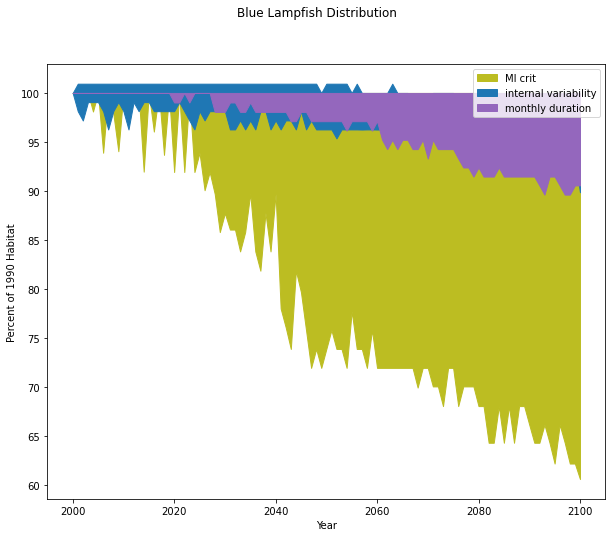

In [196]:
years = np.arange(2000,2101)
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Blue Lampfish Distribution')
ax.fill_between(years, crit_min, crit_max, color='tab:olive', label='MI crit')
ax.fill_between(years, ens_min, ens_max, color='tab:blue', label='internal variability')
ax.fill_between(years, month_min, month_max, color='tab:purple', label ='monthly duration')

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 Habitat')

In [42]:
maximum = [0]*101
minimum = [0]*101
for i in range(101):
    maximum[i] = find_max(crit_max[i], month_max[i], ens_max[i])
    minimum[i] = find_min(crit_min[i], month_min[i], ens_min[i])

In [25]:
allMax = [0]*101
allMin = [0]*101
for i in range(101):
    allMax[i] = find_max(critMax[i], monthMax[i], ensMax[i])
    allMin[i] = find_min(critMin[i], monthMin[i], ensMin[i])

Text(0, 0.5, 'Percent of 2000 Habitat')

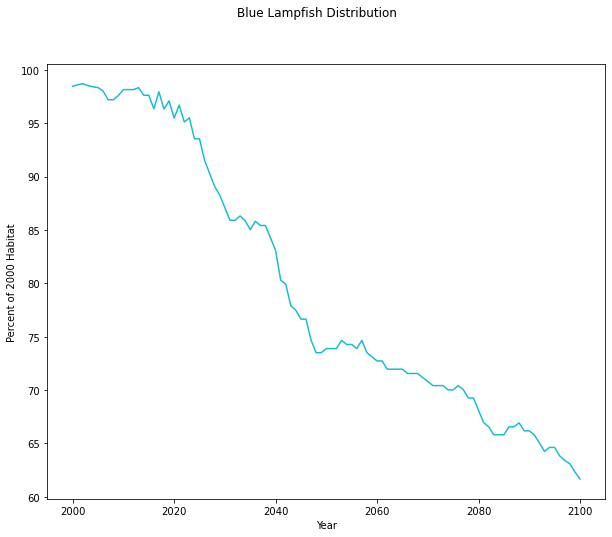

In [28]:
years = np.arange(2000,2101)
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Blue Lampfish Distribution')
ax.plot(years, allMin, color='tab:cyan', label='max')

ax.set_xlabel('Year')
ax.set_ylabel('Percent of 2000 Habitat')

Text(0, 0.5, 'Percent of 2000 Habitat')

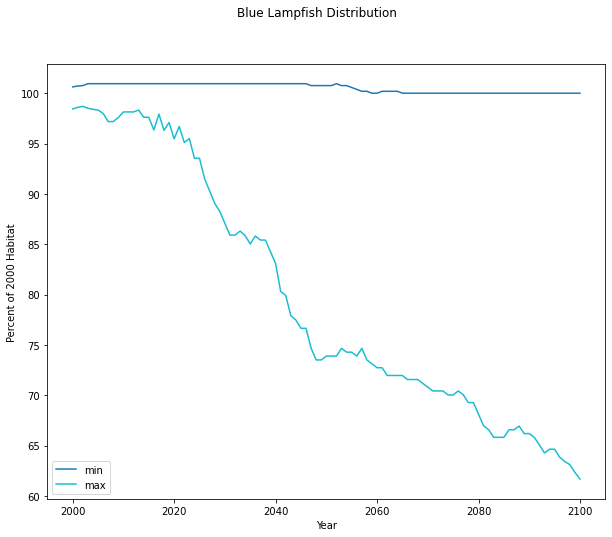

In [27]:
years = np.arange(2000,2101)
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Blue Lampfish Distribution')
ax.plot(years, allMax, color='tab:blue', label='min')
ax.plot(years, allMin, color='tab:cyan', label='max')

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 2000 Habitat')

In [29]:
allDiff = [0]*101
for i in range(101):
    allDiff[i] = allMax[i]-allMin[i]

In [30]:
difference = [0]*101
for i in range(101):
    difference[i] = maximum[i]-minimum[i]
difference[0]=1

NameError: name 'maximum' is not defined

In [47]:
crit = [0]*101
month = [0]*101
ens = [0]*101
total = [0]*101
for i in range(101):
    crit_diff[i] = (crit_max[i]-crit_min[i])
    month_diff[i] = (month_max[i]-month_min[i])
    ens_diff[i] = (ens_max[i]-ens_min[i])
for i in range(101):
    total[i] = crit_diff[i]+month_diff[i]+ens_diff[i]
total[0]=1
for i in range(101):
    crit[i] = (difference[i]*crit_diff[i])/total[i]
    month[i] = (difference[i]*month_diff[i])/total[i]
    ens[i] = (difference[i]*ens_diff[i])/total[i]
added = [0]*101
for i in range(101):
    added[i] = crit[i]+month[i]+ens[i]

In [52]:
crit_line = [0]*101
for i in range(101):
    crit_line[i] = maximum[i]-crit[i]
month_line = [0]*101
for i in range(101):
    month_line[i] = crit_line[i]-month[i]
ens_line = [0]*101
for i in range(101):
    ens_line[i] = month_line[i]-ens[i]

Text(0, 0.5, 'Percent of 1990 Habitat')

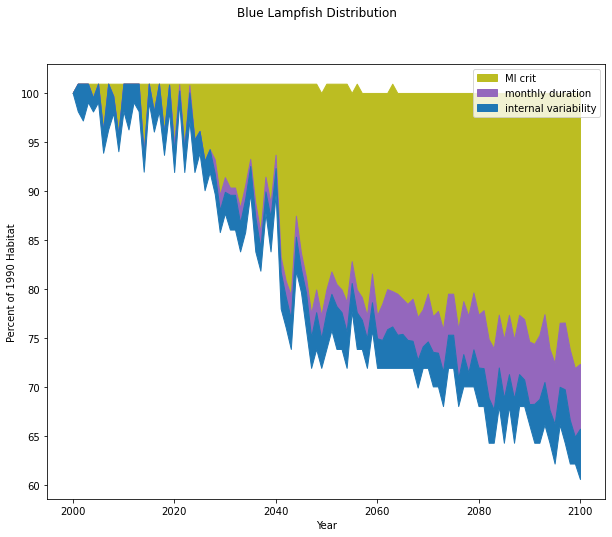

In [53]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Blue Lampfish Distribution')
ax.fill_between(years, maximum, crit_line, color='tab:olive', label='MI crit')
ax.fill_between(years, crit_line, month_line, color='tab:purple', label ='monthly duration')
ax.fill_between(years, month_line, ens_line, color='tab:blue', label='internal variability')

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 Habitat')

In [32]:
Crit = [0]*101
Month = [0]*101
Ens = [0]*101
Total = [0]*101
crit_diff = [0]*101
month_diff = [0]*101
ens_diff = [0]*101
for i in range(101):
    crit_diff[i] = (critMax[i]-critMin[i])
    month_diff[i] = (monthMax[i]-monthMin[i])
    ens_diff[i] = (ensMax[i]-ensMin[i])
for i in range(101):
    Total[i] = crit_diff[i]+month_diff[i]+ens_diff[i]
for i in range(101):
    Crit[i] = (allDiff[i]*crit_diff[i])/Total[i]
    Month[i] = (allDiff[i]*month_diff[i])/Total[i]
    Ens[i] = (allDiff[i]*ens_diff[i])/Total[i]
added = [0]*101
for i in range(101):
    added[i] = Crit[i]+Month[i]+Ens[i]

In [33]:
crit_line = [0]*101
for i in range(101):
    crit_line[i] = allMax[i]-Crit[i]
month_line = [0]*101
for i in range(101):
    month_line[i] = crit_line[i]-Month[i]
ens_line = [0]*101
for i in range(101):
    ens_line[i] = month_line[i]-Ens[i]

Text(0, 0.5, 'Percent of 2000 Habitat')

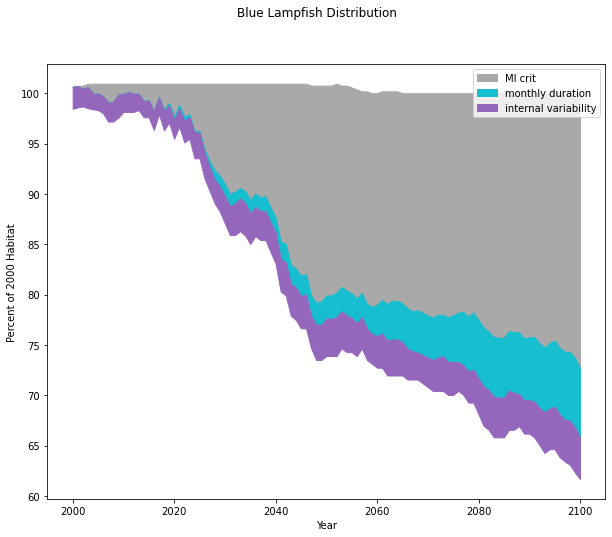

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Blue Lampfish Distribution')
ax.fill_between(years, allMax, crit_line, color='darkgray', label='MI crit')
ax.fill_between(years, crit_line, month_line, color='tab:cyan', label ='monthly duration')
ax.fill_between(years, month_line, ens_line, color='tab:purple', label='internal variability')

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 2000 Habitat')